# Digit Recognizer(Kaggle Competition)

## To Do
* Read Keras implemented models


# Contents
* Preconfiguration
* Preprocessing
   * Loading Images
   * Transformation & Labeling
   * Checking For Balance Data
   * Shuffling
   * Train/Validation Split
   * Remove Outliers 
   * Remove Equal Images
   * Normalization
   * Augmentation
   * One Hot Encoding Labels
* Model Creation
    * simple NN
    * simple CNN
    * LeNet
    * GoogLeNet
    * ResNet
* Training
* Evaluation

## Preconfiguration

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
import keras as K
from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, AveragePooling2D, Dropout
from keras.layers import LeakyReLU,PReLU
from keras.preprocessing.image import ImageDataGenerator
from models.googlenet.inception_v4 import conv_block,inception_A

In [7]:
data_root = 'data'
train_file = os.path.join(data_root,'train.csv')
test_file = os.path.join(data_root,'test.csv')
test_label_file = os.path.join(data_root,'sample_submission.csv')
img_shape = (28,28)

## Preprocessing

### Loading Images

In [8]:
tmp_train = pd.read_csv(train_file)
tmp_test = pd.read_csv(test_file)

In [9]:
tmp_train.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,...,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
23905,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27769,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27792,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33148,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2418,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
tmp_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,...,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Transformation & Labeling

In [11]:
def tranfrom_to_image_shape(data,shape) :
    data = np.array(data)
    img_data = np.ndarray((data.shape[0],shape[0],shape[1]))
    for i,img in enumerate(data) :
        for j,pixel in enumerate(img) :
            img_data[i,int(j/shape[0]),int(j%shape[1])] = pixel
    return img_data
tmp_img_train = tranfrom_to_image_shape(tmp_train.drop('label',axis=1),img_shape)
tmp_img_test = tranfrom_to_image_shape(tmp_test,img_shape)
labels = tmp_train['label']

Making Sure That transformation and labeling are working fine

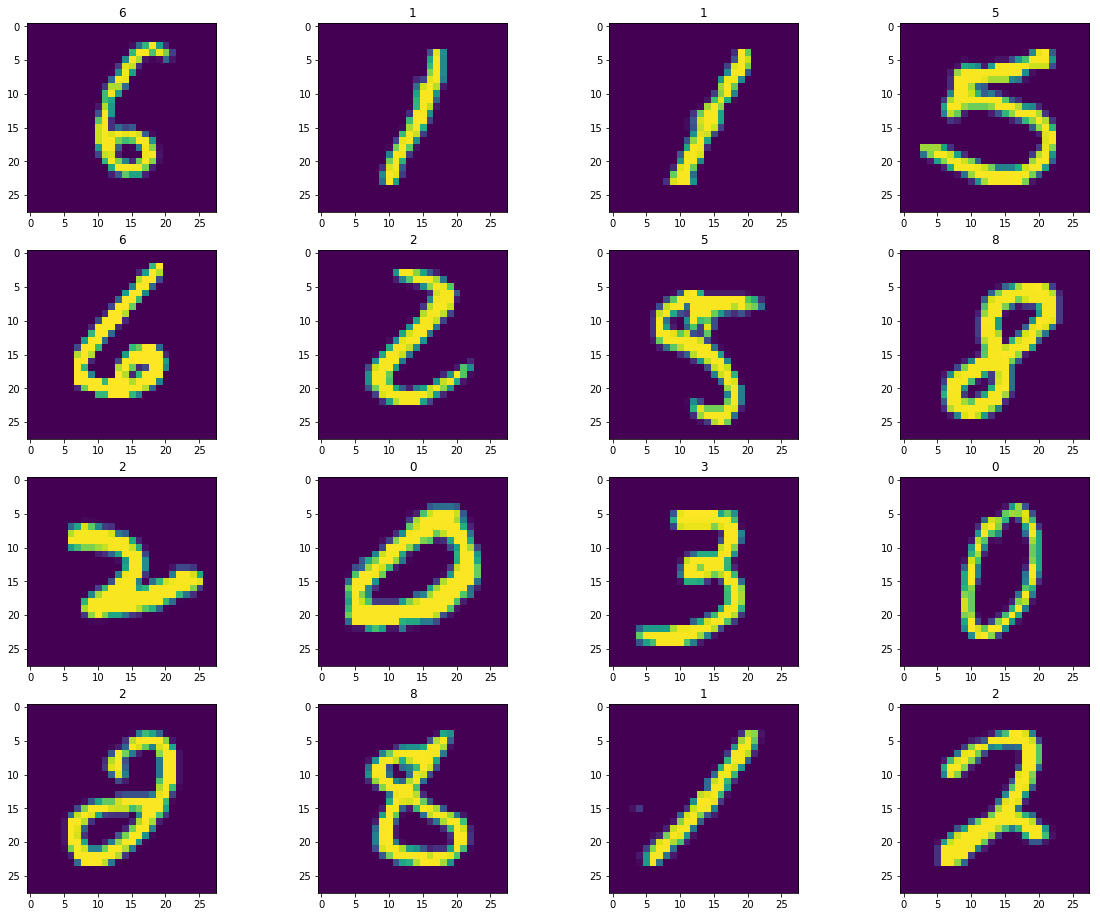

In [12]:
def img_random_visualization(imgs,labels) :
    f,ax = plt.subplots(4,4,figsize=(20,16))
    for i in ax :
        for j in i :
            rnd = np.random.randint(imgs.shape[0])
            j.set_title(labels[rnd])
            j.imshow(imgs[rnd])
img_random_visualization(tmp_img_train,labels)

### Checking For Balance Data

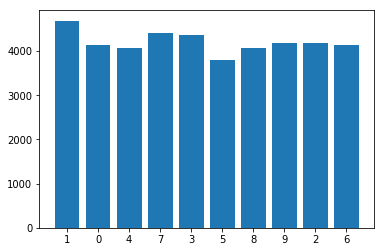

In [13]:
def hist_calc(arr) :
    dic = {}
    for i in arr :
        if i in dic :
            dic[i] += 1
        else :
            dic[i] = 1
    return dic

def hist_visualizer(dic) :
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.show()

hist_visualizer(hist_calc(labels))

As you see data is nearly balanced.

### Shuffling

In [14]:
def shuffle_dataset(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
tmp_img_train,labels = shuffle_dataset(tmp_img_train,labels)

### Train/Validation Split

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(tmp_img_train, labels, test_size=.15)
print('train dataset shape : {} \ntrain label shape : {} \nvalidation dataset shape : {} \nvalidation label shape : {}'.format(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

train dataset shape : (35700, 28, 28) 
train label shape : (35700,) 
validation dataset shape : (6300, 28, 28) 
validation label shape : (6300,)


### Remove Equal Images

In [11]:
def displayIdenticalImgs(dataset) :
    for i,sample in enumerate(dataset) :
        plt.subplot(4,3,1+i)
        plt.axis('off')
        plt.imshow(sample)

def overlapping_measure(dataset_1,dataset_2) :
    similarity_score = 0.0
    similar_images = {}
    similar_imgs_index_2 = []
    for i,m_1 in enumerate(dataset_1) : 
        for j,m_2 in enumerate(dataset_2) :
            if (ssim(m_1,m_2) > .85) : 
                if j not in similar_imgs_index_2 :
                    similarity_score += 1
                    similar_imgs_index_2.append(j)
                if i not in similar_images.keys() :
                    similar_images[i] = []
                    similarity_score += 1
                similar_images[i].append(m_2)
    # calculating the overlapping Score
    overlapping_score = similarity_score / (dataset_1.shape[0] + dataset_2.shape[0])
    return (similar_images,similar_imgs_index_2,overlapping_score)

train_valid_similar_imgs,valid_train_similar_indexes,train_valid_overlapping_score = overlapping_measure(X_train[:1000],X_valid[:1000])
print("train & test dataset Overlapping Percent : %f" % train_valid_overlapping_score)

train & test dataset Overlapping Percent : 0.073000


train & test dataset Overlapping Images : 


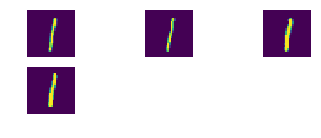

In [12]:
sample = np.random.choice(list(train_valid_similar_imgs.keys()))
print("train & test dataset Overlapping Images : ")
displayIdenticalImgs(np.append([X_train[sample]],train_valid_similar_imgs[sample],axis=0))

### Normalization

In [16]:
X_norm_train = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_train.reshape(-1,*img_shape,1).astype(np.float32)))
X_norm_valid = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_valid.reshape(-1,*img_shape,1).astype(np.float32)))

### Augmentation

In [17]:
augment_config = {
    'featurewise_center':False,
    'samplewise_center':False,
    'featurewise_std_normalization':False,
    'samplewise_std_normalization':False,
    'zca_whitening':False,
    'zca_epsilon':1e-06,
    'rotation_range':0.0,
    'width_shift_range':0.0,
    'height_shift_range':0.0,
    'brightness_range':None,
    'shear_range':0.0,
    'zoom_range':0.0,
    'channel_shift_range':0.0,
    'fill_mode':'nearest',
    'cval':0.0,
    'horizontal_flip':False,
    'vertical_flip':False,
    'rescale':None,
    'preprocessing_function':None,
    'data_format':None,
    'validation_split':0.0
}
img_augment = ImageDataGenerator(**augment_config)

### One Hot Encoding 

In [18]:
y_norm_train = tf.Session().run(tf.one_hot(y_train,10))
y_norm_valid = tf.Session().run(tf.one_hot(y_valid,10))

## Model Creation

In [24]:
def train_model(inputs, predictions,optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) :
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    return model

### Simple Neural Network

In [25]:
def get_nn_model(input_shape,output_shape) :
    # This returns a tensor
    inputs = Input(shape=input_shape)
    # Flattening The Image
    x = Flatten()(inputs)
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(output_shape, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return inputs,predictions

In [26]:
nn_model = train_model(*get_nn_model((*img_shape,1),10))

In [27]:
nn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1
35700/35700 [==============================] - 5s 151us/step - loss: 0.2884 - acc: 0.9128 - val_loss: 0.1563 - val_acc: 0.9494


### Convolutional Neural Network

In [23]:
def get_cnn_model(input_shape,output_shape,activation='selu') :
    inputs = Input(shape=input_shape)
    y = Conv2D(16, 5, padding='same', activation=activation)(inputs)
    y = Conv2D(16, 5, padding='same', activation=activation)(y)
    y = Conv2D(16, 5, padding='same', activation=activation)(y)
    y = Conv2D(16, 5, padding='same', activation=activation)(y)
    y = Conv2D(16, 5, padding='same', activation=activation)(y)

    y = Flatten()(y)
    y = Dense(64, activation=activation)(y)
    y = Dense(64, activation=activation)(y)
    predictions = Dense(10, activation='softmax')(y)

    return inputs,predictions

## CNN with Selu activation

In [21]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10))

In [22]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 39s 1ms/step - loss: 0.4128 - acc: 0.9066 - val_loss: 0.1704 - val_acc: 0.9589
Epoch 2/3
35700/35700 [==============================] - 35s 984us/step - loss: 0.1689 - acc: 0.9589 - val_loss: 0.2185 - val_acc: 0.9511
Epoch 3/3
35700/35700 [==============================] - 40s 1ms/step - loss: 0.1371 - acc: 0.9705 - val_loss: 0.1400 - val_acc: 0.9733


## CNN with Relu activation

In [28]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,'relu'))

In [29]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 17s 489us/step - loss: 0.1733 - acc: 0.9479 - val_loss: 0.0470 - val_acc: 0.9867
Epoch 2/3
35700/35700 [==============================] - 15s 424us/step - loss: 0.0601 - acc: 0.9831 - val_loss: 0.0449 - val_acc: 0.9862
Epoch 3/3
35700/35700 [==============================] - 15s 429us/step - loss: 0.0455 - acc: 0.9876 - val_loss: 0.0624 - val_acc: 0.9797


## CNN with LeakyRelu activation

In [33]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,LeakyReLU()))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\keras\activations.py:186: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [34]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 19s 536us/step - loss: 0.1687 - acc: 0.9483 - val_loss: 0.0698 - val_acc: 0.9783
Epoch 2/3
35700/35700 [==============================] - 20s 571us/step - loss: 0.0802 - acc: 0.9764 - val_loss: 0.1144 - val_acc: 0.9671
Epoch 3/3
35700/35700 [==============================] - 18s 498us/step - loss: 0.0665 - acc: 0.9811 - val_loss: 0.0674 - val_acc: 0.9806


## CNN with Parametric Relu activation

In [ ]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,PReLU()))

In [ ]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

### LeNet

In [15]:
def get_lenet_model(input_shape,output_shape) :
    inputs = Input(shape=input_shape)
    y = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inputs)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.5)(y)
    predictions = Dense(output_shape, activation='softmax')(y)
    return inputs,predictions

In [16]:
lenet_model = train_model(*get_lenet_model((*img_shape,1),10))

In [17]:
lenet_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 14s 382us/step - loss: 0.1985 - acc: 0.9408 - val_loss: 0.0631 - val_acc: 0.9803
Epoch 2/3
35700/35700 [==============================] - 11s 302us/step - loss: 0.0822 - acc: 0.9765 - val_loss: 0.0543 - val_acc: 0.9840
Epoch 3/3
35700/35700 [==============================] - 11s 297us/step - loss: 0.0720 - acc: 0.9792 - val_loss: 0.0539 - val_acc: 0.9841


### Inception V4

In [32]:
def get_inception_v4_model(input_shape,output_shape) :
    '''
    Creates a inception v4 network
    :param nb_classes: number of classes.txt
    :return: Keras Model with 1 input and 1 output
    '''


    init = Input(shape=input_shape)


    x = inception_A(init)

    x = AveragePooling2D()(x)

    # Dropout
    x = Dropout(0.8)(x)
    x = Flatten()(x)

    # Output
    out = Dense(units=output_shape, activation='softmax')(x)


    return init, out

In [ ]:
inception_v4_model = train_model(*get_inception_v4_model((*img_shape,1),10))

In [35]:
inception_v4_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 53s 1ms/step - loss: 13.1653 - acc: 0.1776 - val_loss: 6.7741 - val_acc: 0.5402
Epoch 2/3
35700/35700 [==============================] - 50s 1ms/step - loss: 3.0905 - acc: 0.7692 - val_loss: 0.3783 - val_acc: 0.9527
Epoch 3/3
35700/35700 [==============================] - 49s 1ms/step - loss: 0.4545 - acc: 0.9430 - val_loss: 0.2947 - val_acc: 0.9592
